In [69]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import math
import pandas as pd
from gym import wrappers
from collections import deque
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [70]:
#Parameters
N = 50
X_min = 0
X_max = 100
Y_min = 0
Y_max = 100
O = 10
R_obstacles_max = 10
Safe_radius = 1
Cluster_radius = 10

In [71]:
import pandas as pd 
from collections import deque
import gym

import os 
import numpy as np
from random import sample
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import torch.multiprocessing as mp
from torch.distributions import Categorical,Normal,MultivariateNormal
from multiprocessing.pool import Pool
import random
from rltorch.network import BaseNetwork
import torch
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining functions

In [72]:
import random
from math import sqrt

def calculate_distance(coord1, coord2):
    distance = sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)
    return distance

def calculate_UAV_CH_distance(P_t,P_m):
    distance = sqrt((P_t[0] - P_m[0])**2 + (P_t[1] - P_m[1])**2 + P_t[2]**2)
    return distance

def calculate_power_gain_UAV_CH(beta_o,P_t,P_m):
    distance = calculate_UAV_CH_distance(P_t,P_m)
    power_gain = beta_o/(distance**2)
    return power_gain

def calculate_UAV_CH_transmission_rate(B, P_t, P_m, beta_o, sigma, rho_m):
    power_gain = calculate_power_gain_UAV_CH(beta_o, P_t, P_m)
    transmission_rate = B * np.log2(1 + (rho_m * power_gain)/(sigma**2))
    return transmission_rate

def calculate_UAV_CH_Upload_time(B, P_t, P_m, beta_o, sigma, rho_m, I_m):
    transmission_rate = calculate_UAV_CH_transmission_rate(B, P_t, P_m, beta_o, B , sigma, rho_m)
    upload_time = I_m/transmission_rate
    return upload_time

def calculate_CH_IoTD_distance(P_m, P_n):
    distance = sqrt((P_m[0] - P_n[0])**2 + (P_m[1] - P_n[1])**2)
    return distance

def calculate_CH_IOTD_transmission_rate(B, P_m, P_n, beta_m,rho_n,alpha , rho_i):
    distance = calculate_CH_IoTD_distance(P_m, P_n)
    power_gain = beta_m/(distance**alpha)
    transmission_rate = B * np.log2(1 + (rho_i * power_gain)/(rho_n))
    return transmission_rate

def calculate_UAV_Obstacle_distance(P_t,L_o):
    distance = sqrt((P_t[0]-L_o[0])**2 + (P_t[1]-L_o[1])**2) - L_o[2]
    return distance

def calculate_UAV_travel_energy_per_second(P_o,v_t,U_tip,P_i,v_o,d_o,rho,s,delta):
    energy_per_second = P_o(1+3*(v_t**2)/(U_tip**2)) + P_i*v_o/v_t + d_o*rho*s*delta*(v_t**3)/2
    return energy_per_second

def maximum_minimum_distance_clustering(nodes, cluster_radius):
    cluster_heads = []
    remaining_nodes = nodes.copy()

    cluster_heads.append(remaining_nodes.pop(0))

    while remaining_nodes:
        max_min_distance = 0
        max_min_distance_node = None
        for node in remaining_nodes:
            min_distance = min(calculate_distance(node, ch) for ch in cluster_heads)
            if min_distance > max_min_distance and min_distance > cluster_radius:
                max_min_distance = min_distance
                max_min_distance_node = node
        if max_min_distance_node is None:
            break
        cluster_heads.append(max_min_distance_node)
        remaining_nodes.remove(max_min_distance_node)

    clusters = {ch: [] for ch in cluster_heads}
    for node in remaining_nodes:
        nearest_ch = min(cluster_heads, key=lambda ch: calculate_distance(node, ch))
        clusters[nearest_ch].append(node)

    return clusters

def generate_IoTD_coordinates_outside_obstacles(num_coordinates, Obstacle_coordinates):
    coordinates = []
    xmin = X_min
    xmax = X_max
    ymin = Y_min
    ymax = Y_max
    for i in range(num_coordinates):
        x = random.uniform(xmin, xmax)
        y = random.uniform(ymin, ymax)
        new_coord = (x, y)
        if not any(calculate_distance(new_coord, obstacle) <= obstacle[2] + Safe_radius for obstacle in Obstacle_coordinates):
            coordinates.append(new_coord)
    
    return coordinates

    

def generate_Obstacle_coordinates(num_coordinates):
    coordinates = []
    xmin = X_min
    xmax = X_max
    ymin = Y_min
    ymax = Y_max
    for i in range(num_coordinates):
        x = random.uniform(xmin, xmax)
        y = random.uniform(ymin, ymax)
        r = random.uniform(0, R_obstacles_max)
        new_coord = (x, y, r)
        coordinates.append(new_coord)
    
    return coordinates


Generating the world


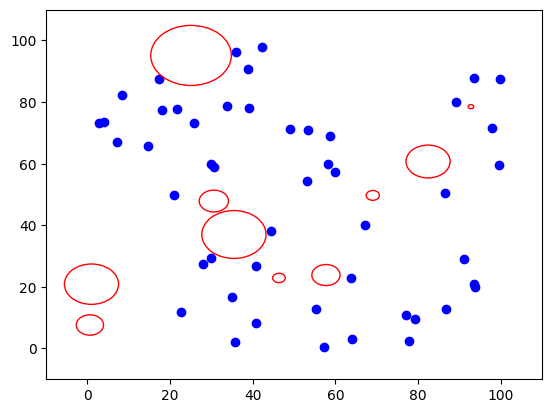

In [73]:
O_obstacles = generate_Obstacle_coordinates(O)
N = generate_IoTD_coordinates_outside_obstacles(N, O_obstacles)
import matplotlib.pyplot as plt

# Plot IoTDs
for coord in N:
    plt.scatter(coord[0], coord[1], color='blue', label='IoTD')
    
# Plot Obstacles
for obstacle in O_obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False)
    plt.gca().add_patch(circle)

# Set plot limits
plt.xlim(X_min - 10, X_max + 10)
plt.ylim(Y_min - 10, Y_max + 10)

# Add legend
# plt.legend()

# Show the plot
plt.show()


Clustering


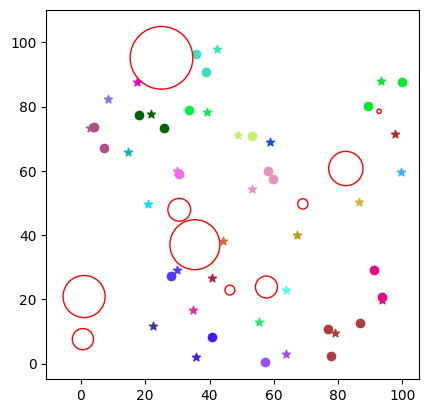

28


In [74]:
Clusters = maximum_minimum_distance_clustering(N, Cluster_radius)

M = []

for cluster_head, cluster_nodes in Clusters.items():
    M.append(cluster_head)

x,y=[node[0] for node in Clusters.keys()],[node[1] for node in Clusters.keys()]
for i in Clusters.keys():
    color=(random.choice(range(256))/255,
           random.choice(range(256))/255,
           random.choice(range(256))/255)
    plt.scatter(i[0],i[1],color=color,marker='*')
    for j in Clusters[i]:
        plt.scatter(j[0],j[1],color=color)
for obstacle in O_obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False)
    plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.show()
print(len(x))





In [76]:
#debugging

[(29.842923639192996, 59.88767957466054), (93.75646013603075, 19.855010862266198), (93.4965458553425, 87.95562993196661), (35.75382614500047, 2.1900958472339305), (42.25943192923241, 97.918549609621), (67.1654249609349, 40.16567194291021), (8.46944844627967, 82.33142778005262), (58.74360250057264, 68.86844611407473), (99.5121084737118, 59.52725711942573), (63.925853957621506, 3.019211562225188), (30.009651340050613, 29.251020219392764), (39.137322622856, 78.23522146117772), (63.78527999433913, 22.973449970217587), (44.30151386579091, 38.0365998893755), (79.13639565415515, 9.511136606876558), (22.523174020151504, 11.768980868215417), (14.752640842083576, 65.80634330611285), (86.59525924241221, 50.368310466207824), (53.19592297140462, 54.27478864384998), (21.72544383153333, 77.79513281704955), (20.884086387706834, 49.76817866008661), (34.944179921901586, 16.836131948514733), (55.41893163402808, 12.802404945839685), (97.79420421197106, 71.57874358445675), (40.897854301015634, 26.627235400

Environment 

In [24]:
class Single_Agent_UAV(gym.Env):
    def __init__(self, initial_UAV_state = None):
        super(Single_Agent_UAV, self).__init__()

        self.initial_UAV_state = np.array([500,500])
        self.UE_count = len(X)
        self.Z = 20
        self.color = ['red', 'green', 'blue', 'cyan', 'magenta']
        self.max_angle = 2 * math.pi
        self.phi_n = np.radians(42.44)  # in degrees
        self.C_max_t = (self.Z / np.tan(self.phi_n))
        self.boundary_x = self.boundary_y = 500.
        self.max_episode_steps = 50 # Maximum number of steps in a single episode, after which environment returns done = True
        self._max_episode_steps = 50
        self.current_episode_timestep = 0
        self.done = False
        self.visited = np.array([0 for i in range(self.UE_count)])
        self.state_space_lb = np.array([0, 0], dtype = np.float32)
        self.state_space_ub = np.array([self.boundary_x, self.boundary_y], dtype = np.float32)
        
        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.UAV_path_color = 'green'
        obh = []
        obl = []
        self.weight = []
        self.visited = np.array([0 for i in range(self.UE_count)])
        for i in range(len(X)+2):
            obh.append(float('inf')) 
        for i in range(len(X)+2):
            obl.append(float('-inf')) 
        high = np.array(obh, dtype=np.float32)
        low = np.array(obl, dtype=np.float32)
        high1 = np.array([len(X), 180.0, 6.0], dtype=np.float32)
        low1 = np.array([0, -180.0, 5.0], dtype=np.float32)
        
        self.observation_space = spaces.Box(low, high)
        #self.action_space = spaces.Box(low=low1, high=high1, dtype=np.float32)
        self.action_space = spaces.Box(-1, 1, (2,), dtype=np.float32)

        self.place_UEs(position="random")


    def reset(self):
        # RANDOMLY SELECTS UAV STARTING POSITION
        self.current_state = self.select_random_state()
        ground_UAV_state = self.current_state[:2]
        self.visited = np.array([0 for i in range(self.UE_count)])
        self.timesteps_in_episode = 0
        self.done = False
        obs = []
        obs.append(self.current_state[0])
        obs.append(self.current_state[1])
        for i in range(len(X)):
            obs.append(-(math.dist(self.UE_positions[i], ground_UAV_state))/1000)
        return np.array(obs)
    
    
    def get_count_of_UEs_covered(self):
        profit = 0
        ground_UAV_state = self.current_state[:2]
        for i in range(self.UE_count):
            if(math.dist(self.UE_positions[i], ground_UAV_state)<=self.C_max_t):
                if(self.visited[i]==0):
                    profit = profit + 100
                    self.visited[i] =1
                else:
                    profit = profit 
            else:
                if(self.visited[i]==0):
                    profit = profit -1
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()
        return profit


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''
        
        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 1, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)


    def step(self, action: np.ndarray):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''
        # action = action.numpy().flatten()
#         err_msg = f"{action!r} ({type(action)}) invalid"
#         assert self.action_space.contains(action), err_msg
#         assert self.current_state is not None, "Call reset before using step method."
        self.timesteps_in_episode += 1
        prev_UAV_state = self.current_state
        self.action_step_size = (action[1]+1.5)*10 #why this multiplication
        _, inside_bounds = self.move(action[0])
        ground_UAV_state = self.current_state[:2]
        # print(type(self.current_state), type(prev_UAV_state))
#         if not inside_bounds:
#             MENTIONED OUTPUT IS OUT OF BOUNDS
#             self.is_done(end = True)
#             reward = -10000
#             return self.current_state, reward, self.done, None

        ground_UAV_state = self.current_state[:2]
        horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
        # self.current_state = np.concatenate((self.current_state[:2], rho_array))
        M_t = rho_array.sum()  # no. of UEs served by the agent

        reward = self.get_count_of_UEs_covered() 
        # if(sum(self.visited)>14):
        #     reward = 100 * sum(self.visited) 
        self.is_done(sum(self.visited))
        obs = []
        obs.append(self.current_state[0])
        obs.append(self.current_state[1])
        for i in range(len(X)):
            if(self.visited[i] == 0):
                obs.append(-(math.dist(self.UE_positions[i], ground_UAV_state))/10000)
            else:
                obs.append(1)
        return obs, reward, self.done, None
    

    def move(self, action):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
#         evaluates new state reached upon performing the move and saves it in self.current_state
        # ACTION = [dx, dy]
#         angle1= math.degrees(math.atan(action))
#         print(angle1)
        angle1 = action * 180
        angle = angle1*math.pi/180
        x_next = self.current_state[0] + (math.cos(angle) * self.action_step_size)
        y_next = self.current_state[1] + (math.sin(angle) * self.action_step_size)
#         print(x_next,y_next)
        
    # updating horizontal_direction_angle if the new move is out of boundary
        if((x_next < 0) or (x_next > self.boundary_x) or (y_next < 0) or (y_next > self.boundary_y)):
            # UAV REMAINS IN ITS CURRENT POSITION
            return action, False

#         print("current_state", self.current_state)
#         print(type(self.current_state))
#         print(np.array([x_next, y_next]))
        self.current_state[:2] = np.array([x_next, y_next])
#         print(self.current_state)
        return action, True


    def is_done(self, M_t=0, end=False):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if end == True:
            self.done = True
        elif(sum(self.visited)>14):
            print(sum(self.visited))
            self.done = True
        elif(self.timesteps_in_episode >= self.max_episode_steps):
            self.done = True
        return

    
    def select_random_state(self):
        '''
        Selects (and returns) random initial state (within bounds) for the UAV
        '''
        new_x = 250.0
        new_y = 250.0
        return np.array([new_x, new_y])

    def place_UEs_randomly(self, random_UE_count = None):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded
        '''

        if random_UE_count is None:
          random_UE_count = self.UE_count

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            x = X[randomly_placed_count][0]
            y = X[randomly_placed_count][1]
            coords = np.array([x, y])
            self.UE_positions.append(coords)
            randomly_placed_count += 1
        

        self.UE_positions = np.array(self.UE_positions)


    def place_UEs(self, position="random"):
        '''
        Function to place UEs onto the rectangular region
        '''
        self.UE_positions = np.zeros((0, 2))
        self.place_UEs_randomly(self.UE_count)

        # saves in self.UE_positions
        self.UE_positions = np.array(self.UE_positions)
        return
    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        buffer = 5.
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-buffer, self.boundary_x+buffer)
        ax.set_ylim(-buffer, self.boundary_y+buffer)
        ax.grid()
        for j in range(len(X)):
            UE_x1 = X[j][0]
            UE_y1 = X[j][1]
            if(self.visited[j] == 0):
                ax.plot(UE_x1, UE_y1, color=self.color[0], marker='o', markersize=6, linestyle = '') 
            else:
                ax.plot(UE_x1, UE_y1, color=self.color[1], marker='o', markersize=6, linestyle = '')

        
        ax.plot(kwargs['UAV_positions_list'][:, 0] , kwargs['UAV_positions_list'][:, 1], color=self.UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
        ax.plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
        UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), self.C_max_t, color = self.UAV_coverage_circle_color)
        ax.add_artist(UAV_coverage_area)

        ax.set_aspect(1)
        # naming the x axis
        ax.set_xlabel('X pos (m)')
        # naming the y axis
        ax.set_ylabel('Y pos (m)')
        ax.set_title('UAV movement through episode')
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax.legend()
#         plt.show()
        return
        
    
    def render_position_plot(self, **kwargs):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        ax = kwargs['ax']
        plot_number = kwargs['i']
        idx = 0
        reward = kwargs['reward']
#         print("Hii")

        buffer = 5.
        ax[plot_number].set_xlim(-buffer, self.boundary_x+buffer)
        ax[plot_number].set_ylim(-buffer, self.boundary_y+buffer)
        ax[plot_number].grid()
        for j in range(len(X)):
            UE_x1 = X[j][0]
            UE_y1 = X[j][1]
            ax[plot_number].plot(UE_x1, UE_y1, color='black', marker='o', markersize=6, linestyle = '')
        
        ax[plot_number].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
        UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
        ax[plot_number].add_artist(UAV_coverage_area)

        if 'learnt_policy_visualization' in kwargs:
            position_action_list = kwargs['position_action_list']
            for position_action in position_action_list:
                position = position_action[0]
                action = position_action[1]
                action = np.clip(action, self.action_space_lb, self.action_space_ub)
                action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
                print("scaled action: ", action)
                # print("action after scaling: ", action)
                new_state = self.move(action, get_new_state=True, provided_center=position)
                print("previous state: ", position, ", new state: ", new_state)
                # print("new_state: ", new_state)
                ax[plot_number].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
                ax[plot_number].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
                ax[plot_number].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


        ax[plot_number].set_aspect(1)
        # naming the x axis
        ax[plot_number].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number].set_ylabel('Y pos (m)')
#         ax[plot_number].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number].legend()
        # plt.show()

[-0.15200977  0.44538036]
[267.2773576120562, 241.05889333421476, -0.0033706004525829456, -0.00519012428341234, -0.00710730840357871, -0.009060368392614876, -0.011030263735569007, -0.013009348974584504, -0.014993985574517435, -0.01698222735907016, -0.016896304419319882, -0.017046235947724826, -0.01742593518123729, -0.018020884381624035, -0.018810670664573304, -0.019771959634953134, -0.020881078630219117, -0.027965780480242976, -0.011601156289730663, -0.013589118847805259, -0.02445412845824687, -0.024894178372842513, -0.010300737231946208, -0.0049986585525129724, -0.00640587724966827, -0.01879274891106965, -0.011082476852987126, -0.009380141069834112] -26
[ 0.6804167  -0.69494087]
[262.9547402736939, 247.8505794594985, -0.0025659737446802854, -0.0044095339294067315, -0.006348524056092862, -0.008316461140833302, -0.010296761341469994, -0.012283446679958827, -0.014273851286726796, -0.016266609934826395, -0.01623024037598689, -0.016438941771076316, -0.01688362847386071, -0.0175463675538238

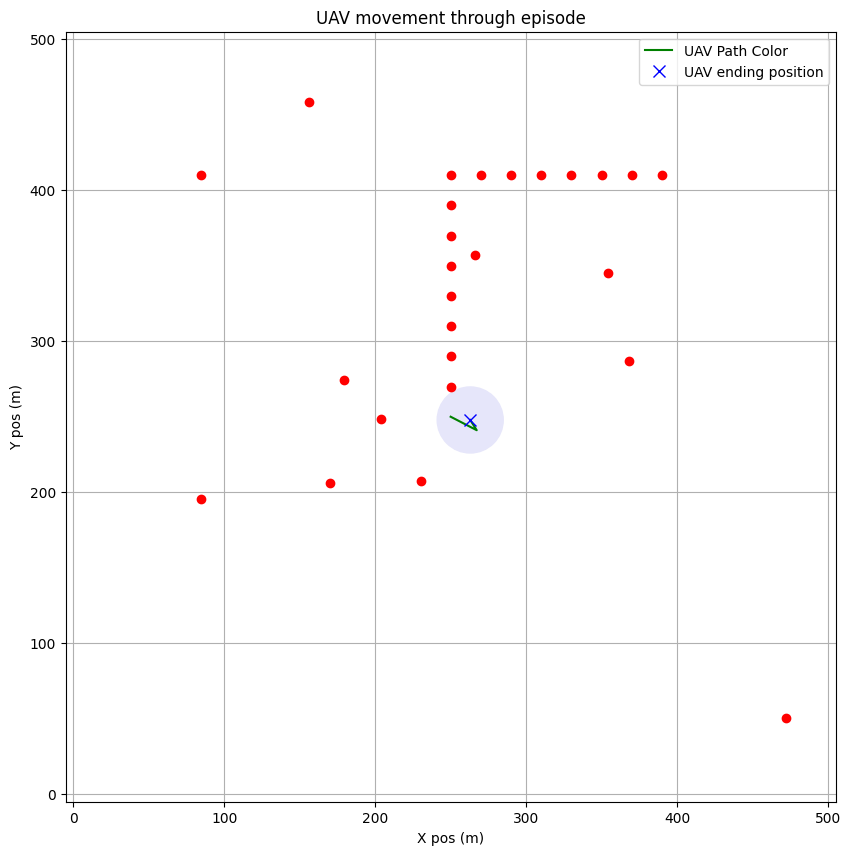

In [25]:
env = Single_Agent_UAV()
state = env.reset()
UAV_positions_list = []
UAV_positions_list.append(state.copy())
a = env.action_space.sample()
print(a)
next_state, reward, done, _ = env.step(a)
print(next_state, reward)
UAV_positions_list.append(next_state.copy())
b = env.action_space.sample()
print(b)
next_state, reward, done, _ = env.step(b)
print(next_state, reward)
UAV_positions_list.append(next_state.copy())
UAV_positions_list = np.array(UAV_positions_list)
print("List",UAV_positions_list)
env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)

In [26]:
def update_params(optim, network, loss, grad_clip=None, retain_graph=False):
    optim.zero_grad()
    loss.backward(retain_graph=retain_graph)
    if grad_clip is not None:
        for p in network.modules():
            torch.nn.utils.clip_grad_norm_(p.parameters(), grad_clip)
    optim.step()


def soft_update(target, source, tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(t.data * (1.0 - tau) + s.data * tau)


def hard_update(target, source):
    target.load_state_dict(source.state_dict())


def grad_false(network):
    for param in network.parameters():
        param.requires_grad = False
        
class V(BaseNetwork):
    def __init__(self, num_inputs, num_actions=env.action_space.shape[0], hidden_units=[256, 256],
                 initializer='xavier'):
        super(V, self).__init__()

        self.value = nn.Sequential(
                            nn.Linear(num_inputs, 128),
                            nn.ReLU(),
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Linear(128, 1))
    def forward(self, x):
        q = self.value(x)
        return q

In [27]:
class Actor(nn.Module):
    def __init__(self,num_in,numact):
        super(Actor,self).__init__()
        
        self.numact=numact
        self.lin1 = nn.Linear(num_in,100)
        self.lin2=nn.Linear(100,100)
        
        self.lin_out=nn.Linear(100,numact)
    def forward(self,state):
        y=T.tanh(self.lin1(state))
        y=T.tanh(self.lin2(y))
        y=T.tanh(self.lin_out(y))
        return y
    def set_std(self,new_action_std):
        self.action_var = torch.full((self.numact,), new_action_std * new_action_std)
        
        
    def get_action(self,state):
        
        means=self.forward(state)
        
        cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
        action_var = self.action_var.expand_as(means)
        dist = MultivariateNormal(means+1e-7, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action+1e-7)
        
        return action.detach(), action_logprob.detach()
    def get_entropy(self,state,action):
        means=self.forward(state)
        action_var = self.action_var.expand_as(means)
        cov_mat = torch.diag_embed(action_var)
      
        dist = MultivariateNormal(means+1e-7, cov_mat)

        action_logprobs = dist.log_prob(action+1e-7)
        dist_entropy = dist.entropy()
 
        
        return action_logprobs, dist_entropy

In [28]:
class Replaybuffer:
    def __init__(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]
    def clear(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]

In [29]:
class Agent:
    def __init__(self,envstr,alpha,beta,gamma,eps_clip,K_epochs,action_std_init,min_action_std,action_std_decay_rate):
        env =Single_Agent_UAV()
        self.act_dim=env.action_space.shape[0]
        self.state_dim=env.observation_space.shape[0]
#         print( self.act_dim)

        self.Actor=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old.load_state_dict(self.Actor.state_dict())
        self.Value=V(env.observation_space.shape[0],1).to(device)
        self.gamma=gamma
        self.Replaybuffer=Replaybuffer()
        self.optimizer=T.optim.Adam([{'params': self.Actor.parameters(), 'lr': alpha},
                        {'params': self.Value.parameters(), 'lr': beta}])
        self.MseLoss=nn.MSELoss()
        self.grad_clip=1
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.action_std=action_std_init
        self.min_action_std=min_action_std
        self.action_std_decay_rate=action_std_decay_rate
        self.Actor.set_std(self.action_std)
        self.grad_clip=1
    def get_action(self,state):
   
        state=T.FloatTensor(np.array(state).reshape(-1,self.state_dim)).to(device)

   
        action,logprob=self.Actor.get_action(state)
        
        self.Replaybuffer.logprobs.append(logprob)
        self.Replaybuffer.states.append(state)
        self.Replaybuffer.actions.append(action)
        
        return action.detach().cpu().numpy()[0]
    def decay_std(self):
        self.action_std = self.action_std - self.action_std_decay_rate
        self.action_std = round(self.action_std, 4)
        if (self.action_std <= self.min_action_std):
            self.action_std = self.min_action_std
        
        self.Actor.set_std(self.action_std)
            
    def update(self):


        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.Replaybuffer.rewards), reversed(self.Replaybuffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            

        rewards = torch.FloatTensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.squeeze(torch.stack(self.Replaybuffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.Replaybuffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.Replaybuffer.logprobs, dim=0)).detach().to(device)


        
        for _ in range(self.K_epochs):
            
            values=self.Value(old_states)
  
            logprobs, dist_entropy = self.Actor.get_entropy(old_states, old_actions)

       
            state_values = torch.squeeze(values)
            
   
            ratios = torch.exp(logprobs - old_logprobs.detach())

  
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
           

            self.optimizer.zero_grad()
            loss.mean().backward()
            for p in self.Actor.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(), self.grad_clip)
            for p in self.Value.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(),self.grad_clip)
            self.optimizer.step()

        self.Actor_old.load_state_dict(self.Actor.state_dict())


        self.Replaybuffer.clear()

In [30]:
episodes = 40000   

       
action_std = 0.6                    
action_std_decay_rate = 0.05       
min_action_std = 0.1                

  
K_epochs = 30        

eps_clip = 0.2         
gamma = 0.99           
max_steps=1000
update=max_steps*4
overallsteps=1500000
lr_actor = 0.0003      
lr_critic = 0.001      
string='Single_Agent_UAV'

In [31]:
agent=Agent(string,lr_actor,lr_critic,gamma,eps_clip,K_epochs,action_std,min_action_std,action_std_decay_rate)

In [32]:
env=Single_Agent_UAV()
step=0
rp=0
scores=[]
while step<=overallsteps:
        interscore=0
            
        state = env.reset()
        done=False
        current_ep_reward = 0
    
        for j in range(max_steps):
            step+=1
            
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            interscore+=reward

            agent.Replaybuffer.rewards.append(reward)
            agent.Replaybuffer.dones.append(done)

            # update PPO agent
            if step % 4000 == 0:
                agent.update()


            if step % 100000 == 0:
                agent.decay_std()
            scores.append(interscore)
            
            if done:
                rp+=1
                if rp%40==0:
                    print(np.mean(scores[-100:]),step)
   
                break

15
-254.81 1993
63.6 3993
-349.11 5993
15
51.86 7982
15
-333.73 9977
15
-117.21 11977
-227.8 13977
15
15
36.23 15951
-57.74 17951
15
15
-36.8 19930
15
-310.79 21921
15
-162.73 23893
15
75.98 25871
15
15
-27.17 27842
-411.61 29842
15
-68.2 31831
15
24.21 33830
15
-136.55 35814
15
-143.94 37813
15
15
-110.2 39797
15
15
30.87 41785
-74.59 43785
15
-92.84 45761
15
132.88 47754
15
-33.89 49753
15
15
-34.6 51737
-14.2 53737
15
-264.62 55719
15
-4.0 57717
-152.19 59717
45.44 61717
-54.47 63717
15
196.35 65716
15
24.49 67698
15
15
11.11 69676
15
15
197.34 71643
15
-216.35 73639
-460.47 75639
39.33 77639
15
15
-284.07 79623
15
116.37 81617
15
-125.62 83612
15
251.21 85596
15
15
15
1.69 87582
15
411.44 89578
15
-106.49 91577
15
15
-367.7 93551
15
24.15 95543
15
-161.32 97529
15
15
129.04 99516
15
15
15
68.34 101495
15
15
15
141.58 103455
15
15
15
15
127.72 105405
15
15
16
-213.06 107387
15
15
15
15
15
15
15
71.68 109324
16
15
15
16
15
15
15
15
15
77.98 111224
15
15
15
2.28 113202
15
15
16
15
15


score 176.0 avg_score 176.0
score 152.0 avg_score 152.0
score 229.0 avg_score 229.0
score 408.0 avg_score 408.0
score 589.0 avg_score 589.0
score 671.0 avg_score 671.0
score 855.0 avg_score 855.0
score 940.0 avg_score 940.0
score 1127.0 avg_score 1127.0
score 1215.0 avg_score 1215.0
15
score 1304.0 avg_score 1304.0


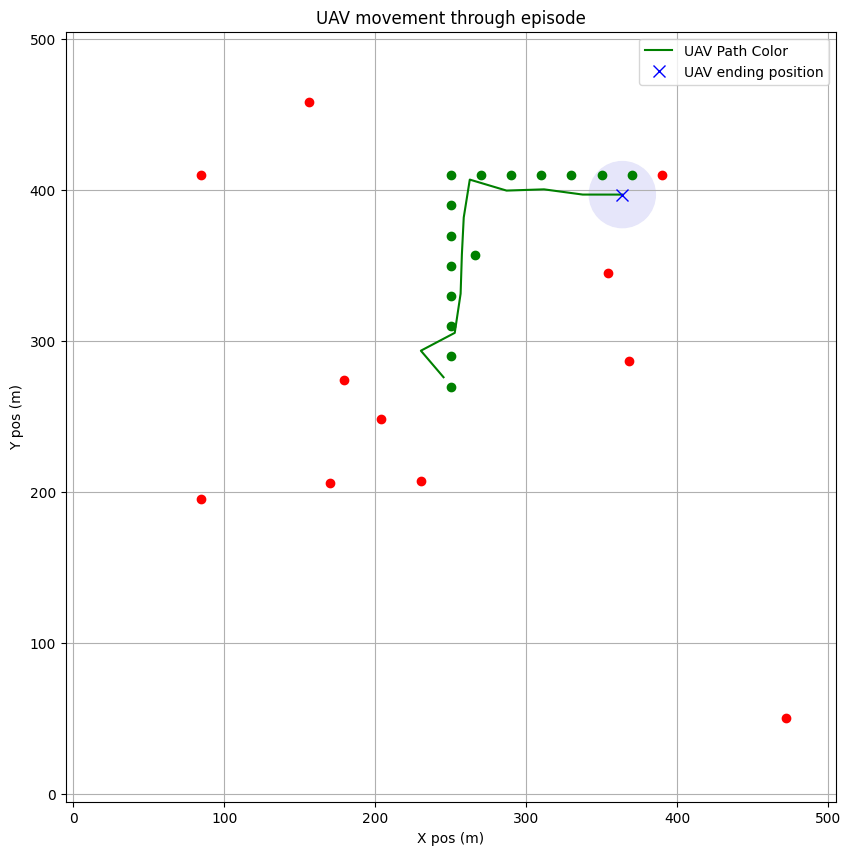

In [33]:
state = env.reset()
done = False
score = 0
UAV_positions_list =[]
while not done:
    action = agent.get_action(state)
    state, reward, done, _ = env.step(action)
    score += reward
    UAV_positions_list.append(state)

    print('score %.1f' % score, 'avg_score %.1f' % score)
UAV_positions_list = np.array(UAV_positions_list)
            # print(UAV_positions_list)
env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)

In [34]:
df=pd.DataFrame(data={'scores':scores})
df['mean']=df.scores.rolling(100).mean()
df

,scores,mean
0,-26,NaN
1,49,NaN
2,24,NaN
3,100,NaN
4,76,NaN
...,...,...
1500003,634,775.86
1500004,621,772.80
1500005,608,768.75
1500006,595,762.69


<Axes: >

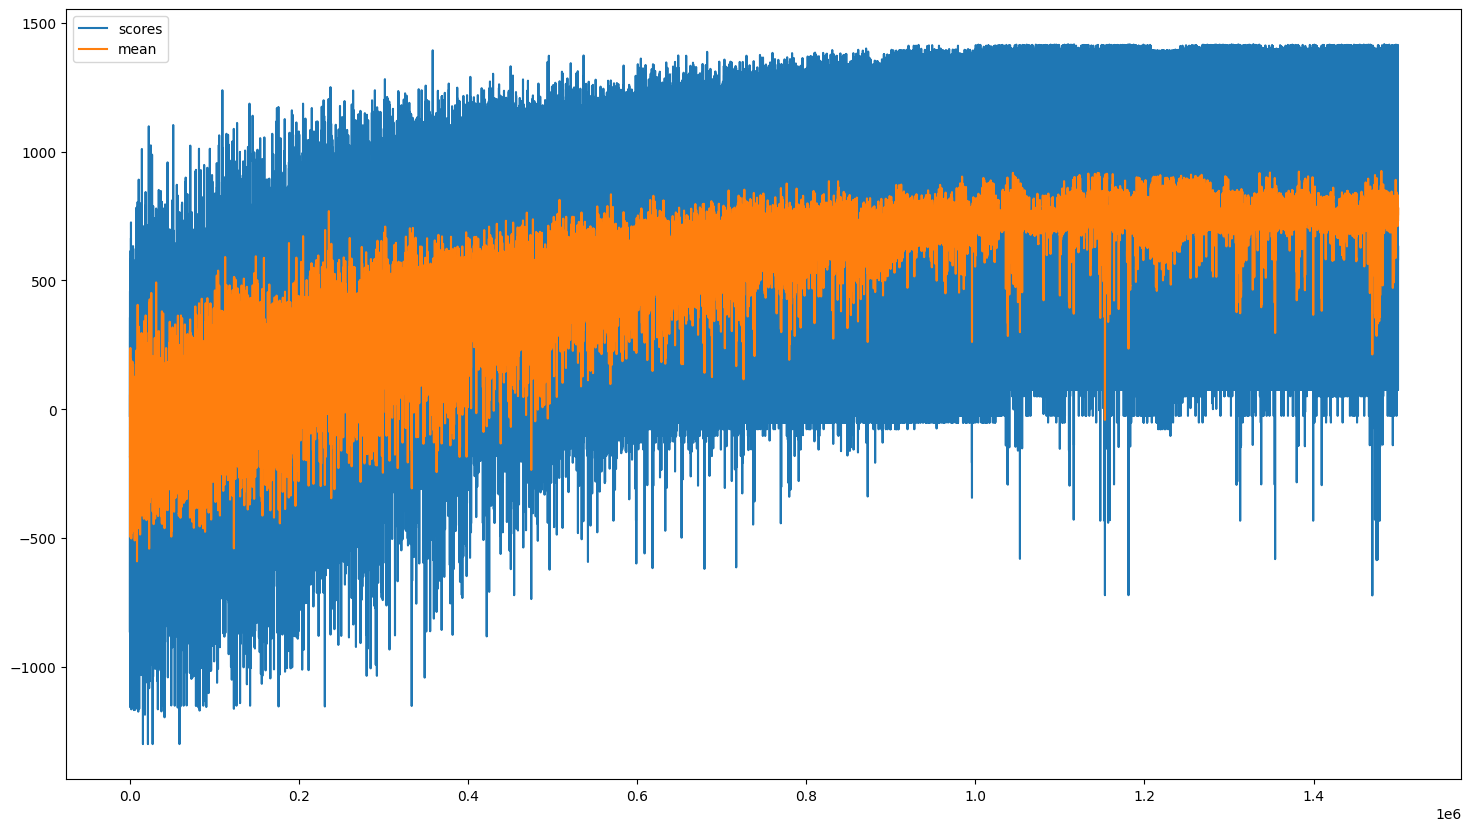

In [35]:
df.plot(figsize=(18,10))